In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns

# Clone github repo
!git clone https://github.com/wwentink/pneumonia-detection.git

Cloning into 'pneumonia-detection'...
remote: Enumerating objects: 5865, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 5865 (delta 4), reused 0 (delta 0), pack-reused 5853 (from 3)
Receiving objects: 100% (5865/5865), 1.13 GiB | 40.08 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Updating files: 100% (5869/5869), done.


In [2]:
# Paths to data
train_dir = "/content/pneumonia-detection/data/chest_xray/train"
val_dir = "/content/pneumonia-detection/data/chest_xray/val"
test_dir = "/content/pneumonia-detection/data/chest_xray/test"

# Overall parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 40

In [3]:
# Create training, validation, and testing datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
print(f"Classes: {class_names}")

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Classes: ['NORMAL', 'PNEUMONIA']


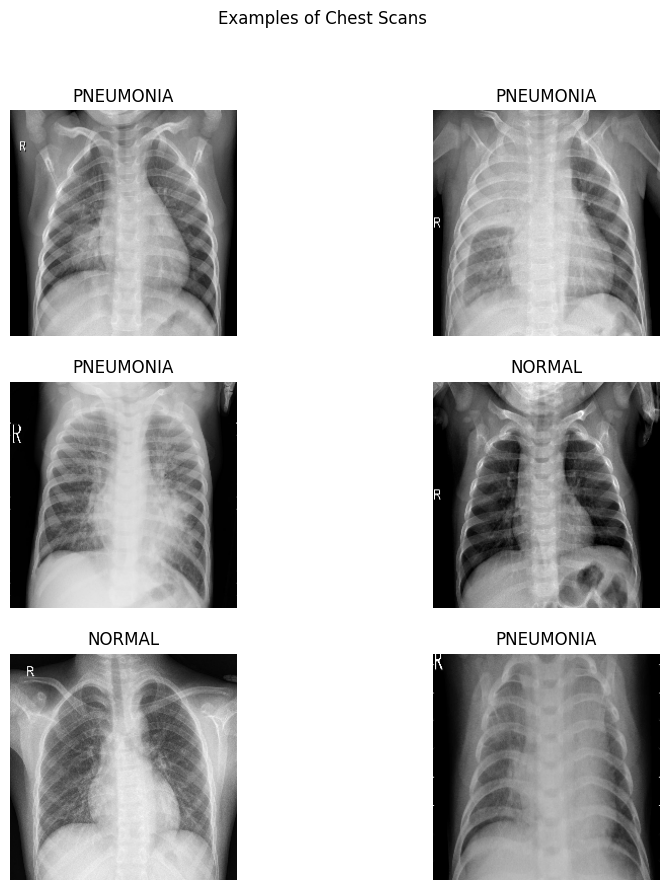

In [4]:
# Visualization
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Examples of Chest Scans")
plt.show()

In [5]:
# Augmentation for training data
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])

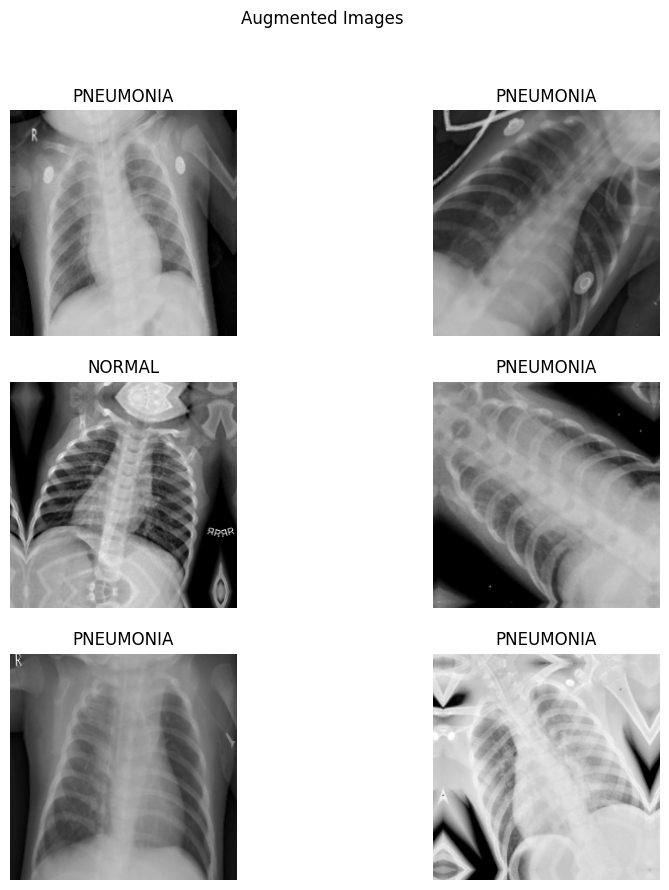

In [6]:
# Ensure images are float and scaled to [0, 1] before augmentation
rescale = tf.keras.layers.Rescaling(1./255)


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    images = rescale(images) # Rescale images
    augmented_images = data_augmentation(images)
    for i in range(6):
        ax = plt.subplot(3, 2, i + 1)
        plt.imshow(np.clip(augmented_images[i].numpy(), 0.0, 1.0))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Augmented Images")
plt.show()

In [7]:
# Autotune to speed up training

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [8]:
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,))

base_model.trainable = False

inputs = layers.Input(shape = IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs, outputs)
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [9]:
# Extract labels from training dataset
y_train = np.concatenate([y.numpy() for x, y in train_ds], axis=0)

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}


In [10]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", "auc"]
)

In [11]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, verbose=1),
    ModelCheckpoint("bestmodel.keras", save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 228ms/step - accuracy: 0.8345 - auc: 0.9002 - loss: 0.3676 - val_accuracy: 0.8750 - val_auc: 1.0000 - val_loss: 0.3062 - learning_rate: 0.0010
Epoch 2/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 205ms/step - accuracy: 0.9048 - auc: 0.9644 - loss: 0.2359 - val_accuracy: 0.8750 - val_auc: 1.0000 - val_loss: 0.2439 - learning_rate: 0.0010
Epoch 3/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 198ms/step - accuracy: 0.9056 - auc: 0.9701 - loss: 0.2173 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.1277 - learning_rate: 0.0010
Epoch 4/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 208ms/step - accuracy: 0.9244 - auc: 0.9770 - loss: 0.1869 - val_accuracy: 0.9375 - val_auc: 1.0000 - val_loss: 0.1325 - learning_rate: 0.0010
Epoch 5/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 207ms/step - accuracy: 0.9225 - auc: 0.9798 - loss: 0.1779 - val_accuracy: 0.9375 - val_auc: 1.0000 - val_loss: 0.1622 - learning_rate: 0.0010
Epoch 6/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 34s 206ms/step - accuracy

In [12]:
base_model.trainable = True
for layer in base_model.layers[:-100]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", "auc"]
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 62s 236ms/step - accuracy: 0.8227 - auc: 0.8982 - loss: 0.4114 - val_accuracy: 0.8125 - val_auc: 0.9844 - val_loss: 0.2865 - learning_rate: 1.0000e-05
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 38s 224ms/step - accuracy: 0.8913 - auc: 0.9660 - loss: 0.2401 - val_accuracy: 0.8125 - val_auc: 0.9688 - val_loss: 0.3326 - learning_rate: 1.0000e-05
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 37s 224ms/step - accuracy: 0.9120 - auc: 0.9745 - loss: 0.2048 - val_accuracy: 0.8750 - val_auc: 0.9844 - val_loss: 0.2805 - learning_rate: 1.0000e-05
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 36s 224ms/step - accuracy: 0.9149 - auc: 0.9792 - loss: 0.1855 - val_accuracy: 0.8750 - val_auc: 1.0000 - val_loss: 0.2748 - learning_rate: 1.0000e-05
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 37s 224ms/step - accuracy: 0.9228 - auc: 0.9828 - loss: 0.1683 - val_accuracy: 0.9375 - val_auc: 1.0000 - val_loss: 0.2240 - learning_rate: 1.0000e-05
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 37s 2

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.8665 - auc: 0.6432 - loss: 0.3648
Test Accuracy: 0.9022
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step
              precision    recall  f1-score   support

      NORMAL       0.92      0.81      0.86       234
   PNEUMONIA       0.89      0.96      0.92       390

    accuracy                           0.90       624
   macro avg       0.91      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624



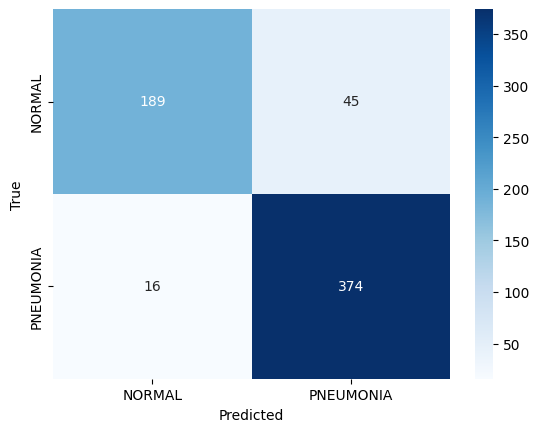

In [13]:
loss, acc, auc = model.evaluate(test_ds)
print(f"Test Accuracy: {acc:.4f}")

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["NORMAL", "PNEUMONIA"],
            yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()